# Multi-Binary Classification
In this notebook, we reformulate the problems as 3 binary classification problems. We train a neural net to output 3 binary classification scores. 

In [1]:
import os
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import pickle

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
batch_size=32

## Save Image Data as Numpy Arrays, and Generate Binary Labels

In [4]:
array_datagen = ImageDataGenerator()

In [43]:
n0 = 4467; n1 = 828; n2 = 389; n3 = 211; N_trn = n0+n1+n2+n3; N_tst = 1538

In [9]:
train_generator = array_datagen.flow_from_directory(
        path+'split_patients/train/', 
        target_size=(256, 320),  
        batch_size=N_trn,
        shuffle=False,
        class_mode='categorical')
validation_generator = array_datagen.flow_from_directory(
        path+'split_patients/validation/',
        target_size=(256, 320),
        batch_size=N_tst,
        shuffle=False,
        class_mode='categorical')

Found 5895 images belonging to 4 classes.
Found 1538 images belonging to 4 classes.


In [10]:
X_trn, Y_trn = next(train_generator)

In [13]:
X_tst, Y_tst = next(validation_generator)

In [16]:
np.save(path+'array_data/image_array_256_320_train.npy', X_trn)

In [17]:
np.save(path+'array_data/image_array_256_320_test.npy', X_tst)

In [18]:
np.save(path+'array_data/class_labels_train.npy', Y_trn)
np.save(path+'array_data/class_lables_test.npy', Y_tst)

In [26]:
y_trn = Y_trn.argmax(axis=1)
y_tst = Y_tst.argmax(axis=1)

In [24]:
binary_label_trn = np.zeros([Y_trn.shape[0], Y_trn.shape[1]-1], dtype=int)
binary_label_tst = np.zeros([Y_tst.shape[0], Y_tst.shape[1]-1], dtype=int)

In [51]:
binary_label_trn[:, 0] = (y_trn != 0)
binary_label_trn[:, 1] = (y_trn == 2) | (y_trn == 3)
binary_label_trn[:, 2] = (y_trn == 3)

binary_label_tst[:, 0] = (y_tst != 0)
binary_label_tst[:, 1] = (y_tst == 2) | (y_tst == 3)
binary_label_tst[:, 2] = (y_tst == 3)

In [52]:
np.save(path+'array_data/binary_labels_train.npy', binary_label_trn)
np.save(path+'array_data/binary_labels_test.npy', binary_label_tst)

## Fine Tuning

In [5]:
X_trn = np.load(path+'array_data/image_array_256_320_train.npy')
X_tst = np.load(path+'array_data/image_array_256_320_test.npy')
binary_label_trn = np.load(path+'array_data/binary_labels_train.npy')
binary_label_tst = np.load(path+'array_data/binary_labels_test.npy')

In [6]:
from keras.applications.inception_v3 import InceptionV3

In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(3, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [62]:
for layer in base_model.layers:
    layer.trainable = False

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=model_path+'binary_inceptionv3_trn_top.h5', verbose=0, save_best_only=True, 
                               save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='loss', patience=5)

In [19]:
trntop_gen = ImageDataGenerator()

trn_gen = trntop_gen.flow(X_trn, binary_label_trn, batch_size=batch_size)
tst_gen = trntop_gen.flow(X_tst, binary_label_tst, batch_size=batch_size, shuffle=False## History Visualization

with open('output/inceptionv3_e2e0212.pkl', 'rb') as f:
    hist = pickle.load(f)

hist.keys()

plt.figure(figsize=(15, 4))
plt.plot(hist['val_loss']))

In [64]:
history = model.fit_generator(trn_gen, steps_per_epoch=trn_gen.n // batch_size, epochs=10, 
                              validation_data=tst_gen, validation_steps=tst_gen.n // batch_size, 
                              callbacks=[checkpointer, reduce_lr, earlystop], 
                                verbose=1)

Epoch 1/10
184/184 [==============================] - 113s 613ms/step - loss: 0.2783 - acc: 0.8946 - val_loss: 0.4520 - val_acc: 0.8019
Epoch 2/10
184/184 [==============================] - 110s 599ms/step - loss: 0.2006 - acc: 0.9235 - val_loss: 0.4969 - val_acc: 0.8164
Epoch 3/10
184/184 [==============================] - 111s 605ms/step - loss: 0.1774 - acc: 0.9319 - val_loss: 0.4786 - val_acc: 0.8077
Epoch 4/10
184/184 [==============================] - 112s 606ms/step - loss: 0.1590 - acc: 0.9396 - val_loss: 0.5099 - val_acc: 0.8149
Epoch 5/10
184/184 [==============================] - 112s 608ms/step - loss: 0.1547 - acc: 0.9404 - val_loss: 0.5006 - val_acc: 0.8088
Epoch 6/10
184/184 [==============================] - 112s 608ms/step - loss: 0.1446 - acc: 0.9430 - val_loss: 0.5297 - val_acc: 0.8132
Epoch 7/10
184/184 [==============================] - 112s 607ms/step - loss: 0.1394 - acc: 0.9447 - val_loss: 0.5198 - val_acc: 0.8147
Epoch 8/10
184/184 [============================

In [65]:
model.save_weights(model_path+'binary_inceptionv3_trntop_f.h5')

## History Visualization

In [23]:
with open('output/binary_inceptionv3_e2e0212.pkl', 'rb') as f:
    hist = pickle.load(f)

In [24]:
hist.keys()

dict_keys(['val_loss', 'lr', 'loss', 'val_acc', 'acc'])

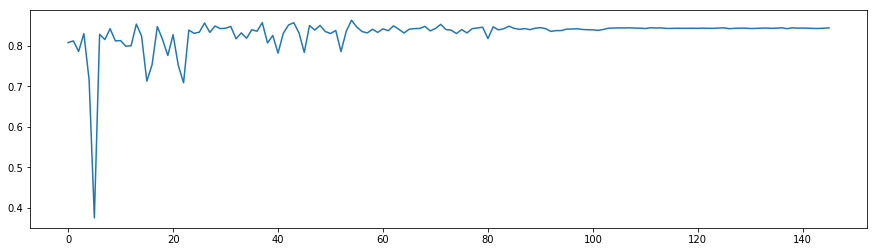

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(hist['val_acc'])

In [28]:
np.array(hist['val_loss']).argmin()

17

## Model Evaluation

In [9]:
import pandas as pd
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [17]:
model.load_weights(model_path+'binary_inceptionv3_e2e0212.h5')

In [20]:
y_pred = model.predict_generator(tst_gen)

In [13]:
y_true = binary_label_tst

In [14]:
legends = {0:'0_123', 1:'01_23', 2:'012_3'}

In [21]:
n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

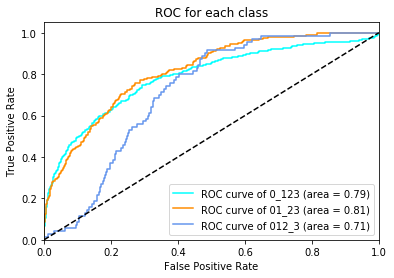

In [22]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(legends[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for each class')
plt.legend(loc="lower right")

In [32]:
y_pred

array([[  5.45838499e-04,   2.40623151e-04,   1.54403606e-05],
       [  1.02562755e-01,   1.84402511e-01,   2.50797690e-04],
       [  3.93863231e-01,   3.79657358e-01,   8.73501040e-03],
       ..., 
       [  7.39346027e-01,   1.43529279e-02,   1.39018302e-04],
       [  1.79509446e-01,   1.52357653e-01,   1.77870551e-03],
       [  4.79531974e-01,   2.76607066e-01,   9.36566200e-03]], dtype=float32)